## Import Libraries and Data

In [1]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

sns.set_theme()

In [2]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

In [3]:
df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)

### EDA

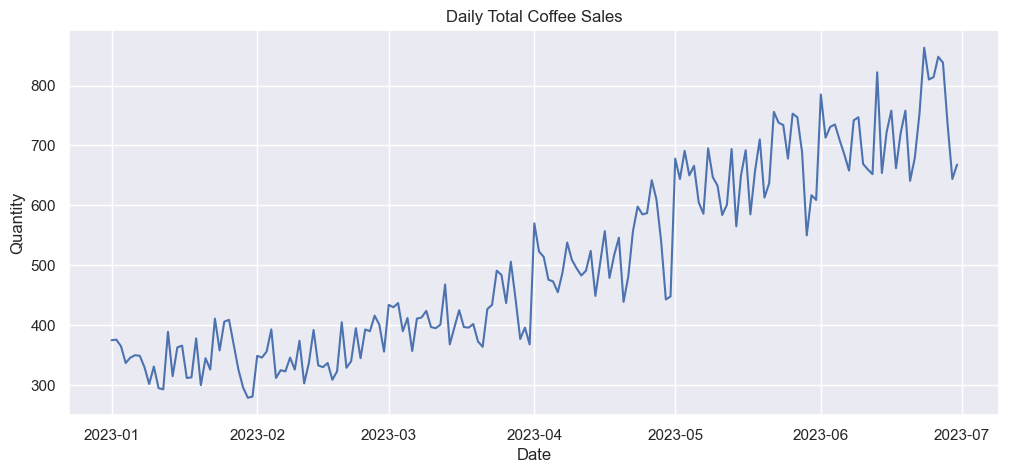

In [4]:
plt.figure(figsize= (12,5))
sns.lineplot(data=df_coffee, x='Date', y='Quantity').set(title = 'Daily Total Coffee Sales')
plt.show()

In [5]:
df_coffee

,Date,Quantity
0,2023-01-01,375
1,2023-01-02,376
2,2023-01-03,365
3,2023-01-04,337
4,2023-01-05,346
...,...,...
176,2023-06-26,848
177,2023-06-27,838
178,2023-06-28,734
179,2023-06-29,644


In [6]:
trend_stationary(df_coffee,'Quantity')

ADF statistic is 0.89
the p-value of this series is 0.99 and is therefore not stationary.
We cannot reject the null hypothesis of a unit root


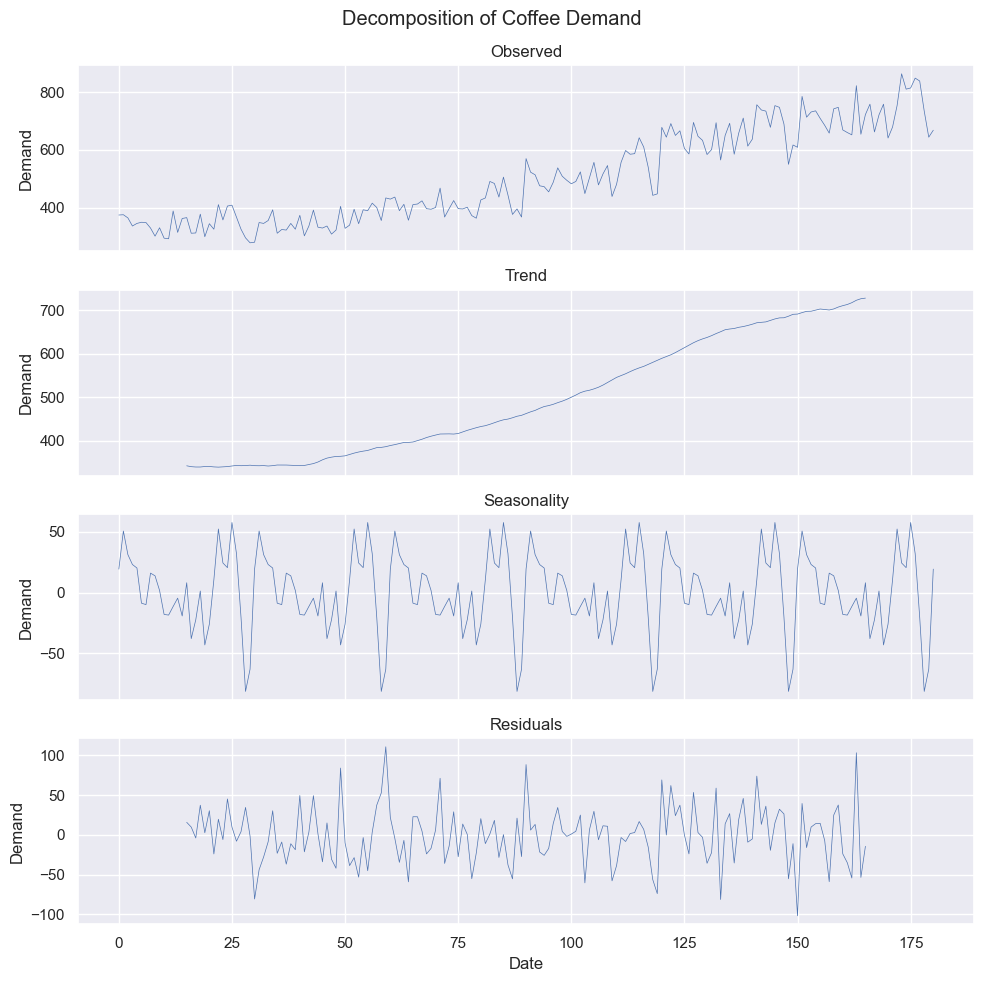

In [7]:
time_series_decomposition(df_coffee['Quantity'], plot_title= 'Decomposition of Coffee Demand', plot_y= "Demand")

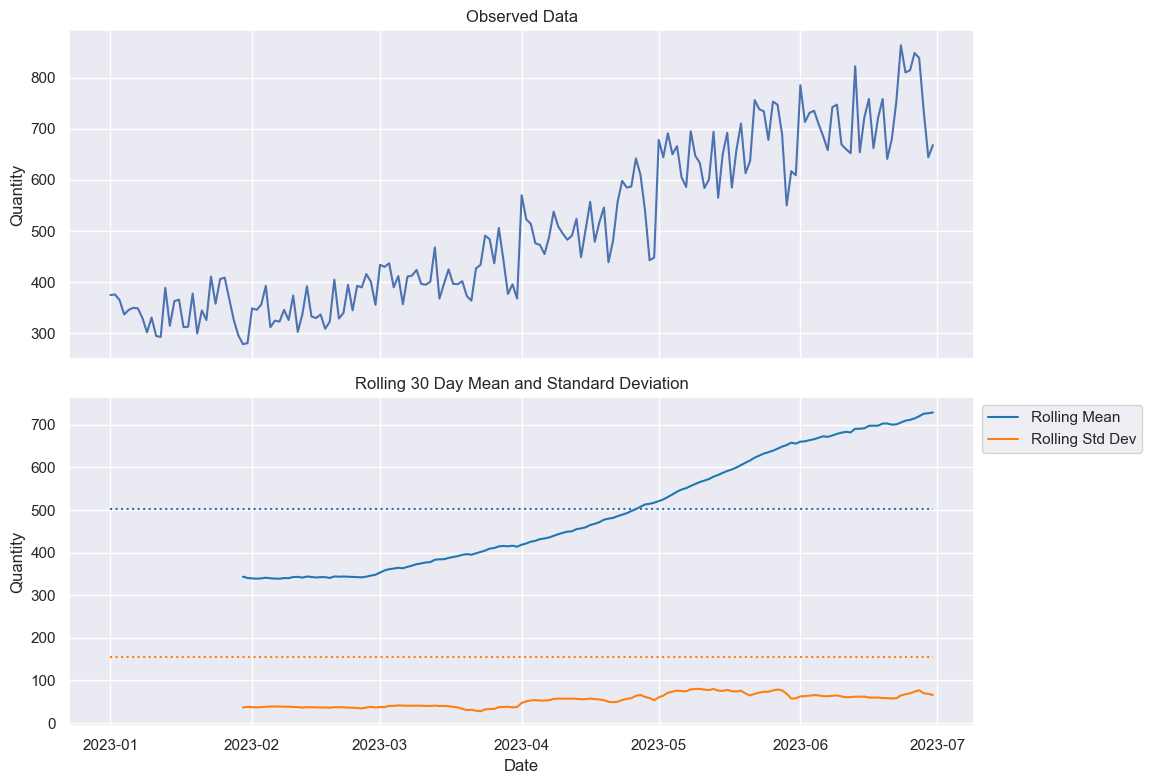

In [8]:
df_coffee_stat = df_coffee.copy()

df_coffee_stat['rolling mean'] = df_coffee['Quantity'].rolling(window=30).mean()
df_coffee_stat['rolling std'] = df_coffee['Quantity'].rolling(window=30).std()
df_coffee_stat['overall_mean'] = df_coffee['Quantity'].mean()
df_coffee_stat['overall_std'] = df_coffee['Quantity'].std()

tb_blue = '#1f77b4'
tb_orange = '#ff7f0e'

fig, axes= plt.subplots(2,1, figsize=(10, 8),sharex=True)

sns.lineplot(data=df_coffee_stat, x='Date',y='Quantity',errorbar=None, ax=axes[0])
sns.lineplot(df_coffee_stat,x='Date', y='rolling mean',errorbar=None,ax=axes[1],color=tb_blue)
sns.lineplot(df_coffee_stat,x='Date', y='rolling std',errorbar=None,ax=axes[1],color=tb_orange)
sns.lineplot(df_coffee_stat,x='Date',y='overall_mean',errorbar=None,ax=axes[1],linestyle = ':',color=tb_blue)
sns.lineplot(df_coffee_stat,x='Date',y='overall_std',errorbar=None,ax=axes[1],linestyle = ':',color= tb_orange)
             
axes[0].set(title = 'Observed Data',
       xlabel = 'Date',
       ylabel='Quantity')
#axes[0].set_ylim(-1.5,1.5)

axes[1].set(title = 'Rolling 30 Day Mean and Standard Deviation',
       xlabel = 'Date',
       ylabel='Quantity')
axes[1].legend(loc="upper left", labels=[ "Rolling Mean", "Rolling Std Dev"])
#axes[1].set_ylim(-1.5,1.5)

plt.tight_layout()
plt.savefig(f'Images/Stationarity/Original.png')

sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))


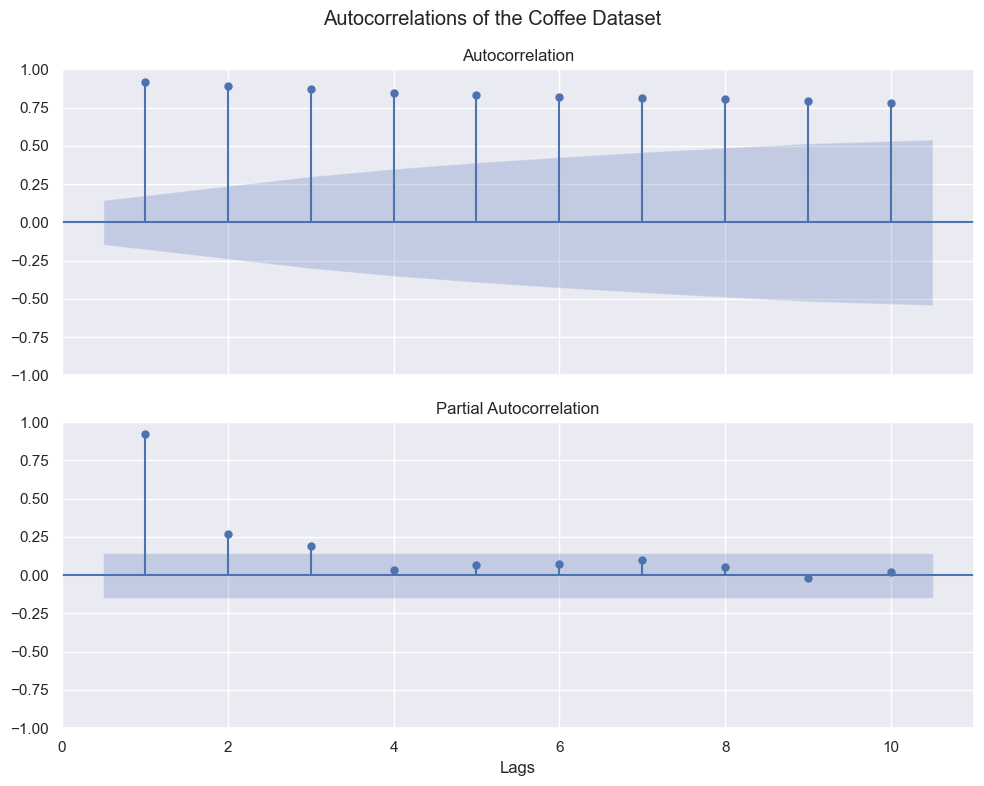

In [9]:
acf_pacf(df_coffee['Quantity'],"Autocorrelations of the Coffee Dataset")

### Make Stationary

In [10]:
scaler_bc = StandardScaler()
scaler_log = StandardScaler()

In [11]:
df_coffee_stationary = df_coffee.copy()

#apply box cox to only the training set
df_coffee_stationary = df_coffee_stationary[df_coffee_stationary['Date'] <= '2023-05-31']

df_coffee_stationary['Quantity_log'] = np.log(df_coffee_stationary['Quantity'])
df_coffee_stationary['Quantity_BC'], lam = boxcox(df_coffee_stationary['Quantity'])

df_coffee_stationary['Scaled_Quantity_log'] = scaler_log.fit_transform(df_coffee_stationary[['Quantity_log']])
df_coffee_stationary['Scaled_Quantity_BC'] = scaler_bc.fit_transform(df_coffee_stationary[['Quantity_BC']])

df_coffee_stationary['Difference'] = df_coffee_stationary['Quantity'].diff()

df_coffee_stationary['Difference_log'] = df_coffee_stationary['Quantity_log'].diff()
df_coffee_stationary['Difference_BC'] = df_coffee_stationary['Quantity_BC'].diff()

df_coffee_stationary['Difference_Scaled_log'] = df_coffee_stationary['Scaled_Quantity_log'].diff()
df_coffee_stationary['Difference_Scaled_BC'] = df_coffee_stationary['Scaled_Quantity_BC'].diff()

print(f'Box-Cox Transformation \u03BB = {lam:.2f}')

df_coffee_stationary

Box-Cox Transformation λ = -0.78


,Date,Quantity,Quantity_log,Quantity_BC,Scaled_Quantity_log,Scaled_Quantity_BC,Difference,Difference_log,Difference_BC,Difference_Scaled_log,Difference_Scaled_BC
0,2023-01-01,375,5.926926,1.267371,-0.622177,-0.572682,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,376,5.929589,1.267397,-0.612116,-0.561042,1.0,0.002663,0.000026,0.010061,0.011640
2,2023-01-03,365,5.899897,1.267105,-0.724285,-0.692201,-11.0,-0.029692,-0.000292,-0.112169,-0.131159
3,2023-01-04,337,5.820083,1.266285,-1.025805,-1.060231,-28.0,-0.079814,-0.000820,-0.301520,-0.368030
4,2023-01-05,346,5.846439,1.266562,-0.926239,-0.936155,9.0,0.026356,0.000276,0.099566,0.124076
...,...,...,...,...,...,...,...,...,...,...,...
146,2023-05-27,747,6.616065,1.272564,1.981229,1.758813,-6.0,-0.008000,-0.000045,-0.030222,-0.020366
147,2023-05-28,689,6.535241,1.272090,1.675895,1.545757,-58.0,-0.080824,-0.000475,-0.305334,-0.213056
148,2023-05-29,550,6.309918,1.270597,0.824678,0.875576,-139.0,-0.225323,-0.001493,-0.851217,-0.670181
149,2023-05-30,617,6.424869,1.271391,1.258935,1.232200,67.0,0.114951,0.000794,0.434257,0.356623


#### Rolling Means and Standard Deviations

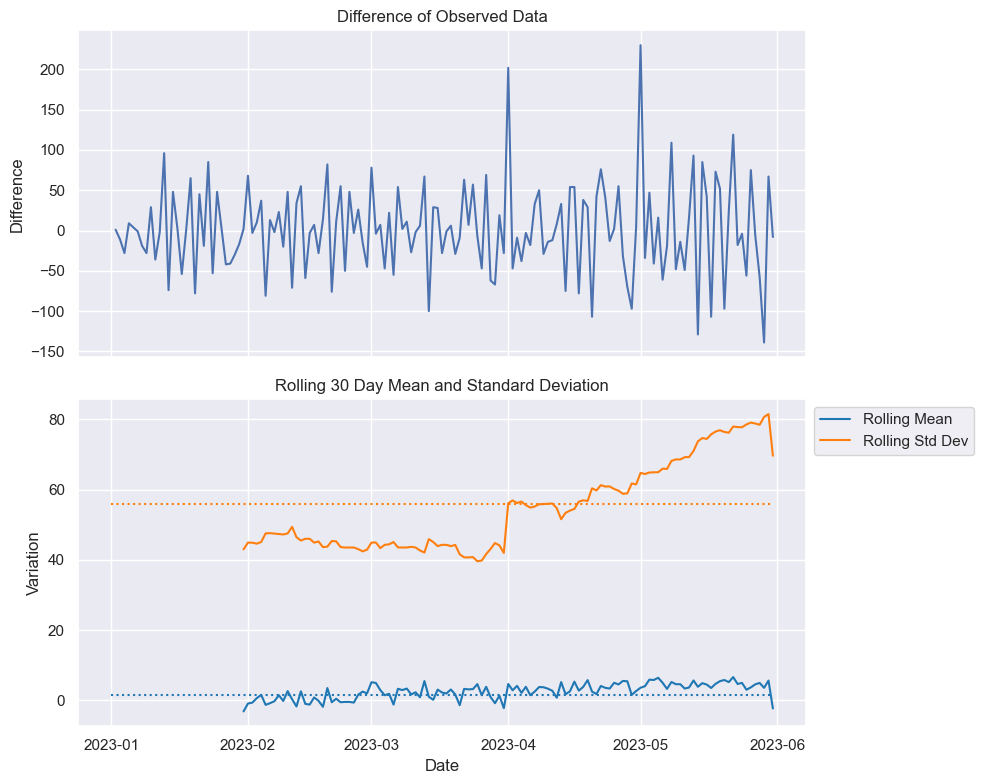

In [12]:
mean_std_view(df_coffee_stationary, 'Difference', title = 'Difference of Observed Data')

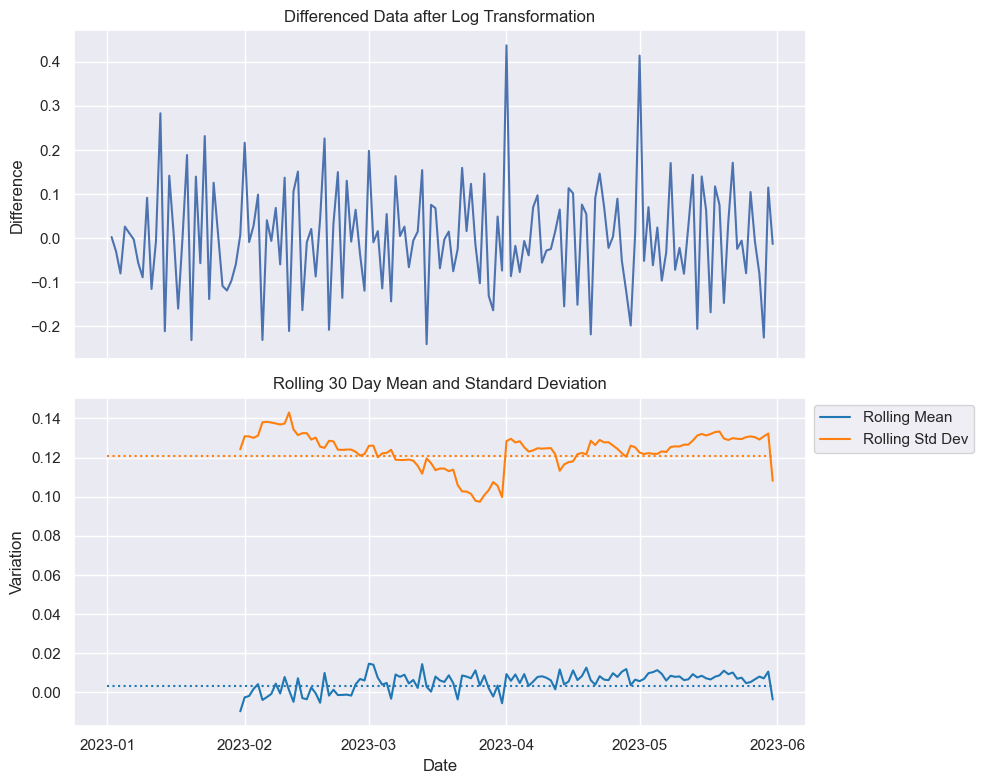

In [13]:
mean_std_view(df_coffee_stationary,'Difference_log',title = 'Differenced Data after Log Transformation')

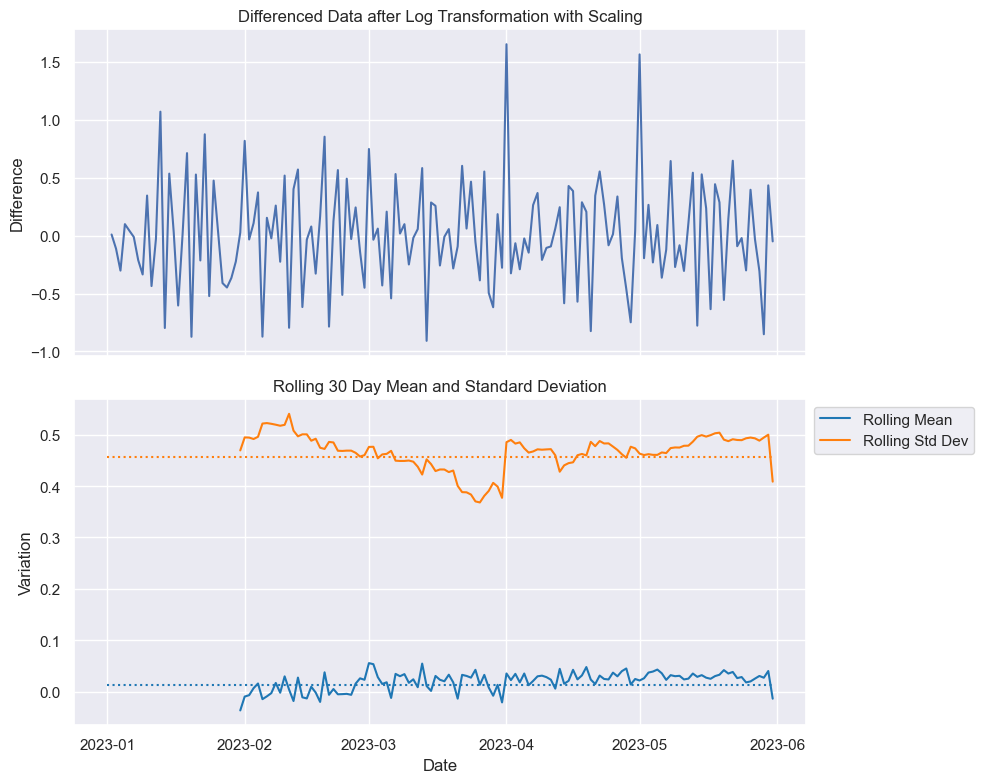

In [14]:
mean_std_view(df_coffee_stationary,'Difference_Scaled_log',title = 'Differenced Data after Log Transformation with Scaling')

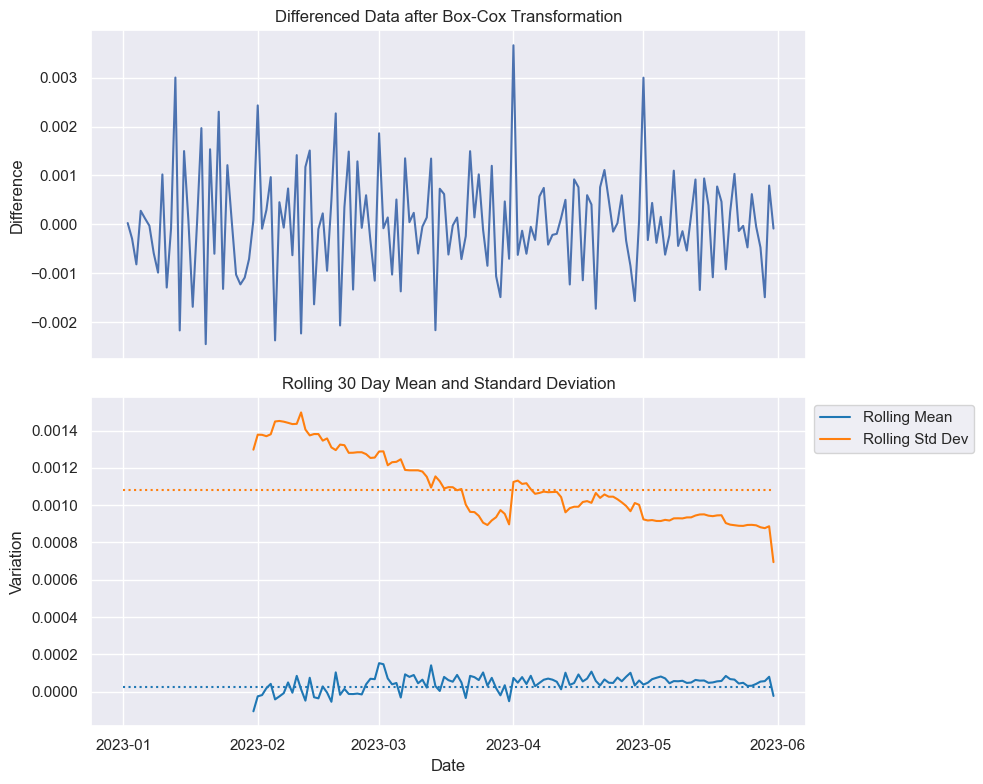

In [15]:
mean_std_view(df_coffee_stationary,'Difference_BC',title='Differenced Data after Box-Cox Transformation')

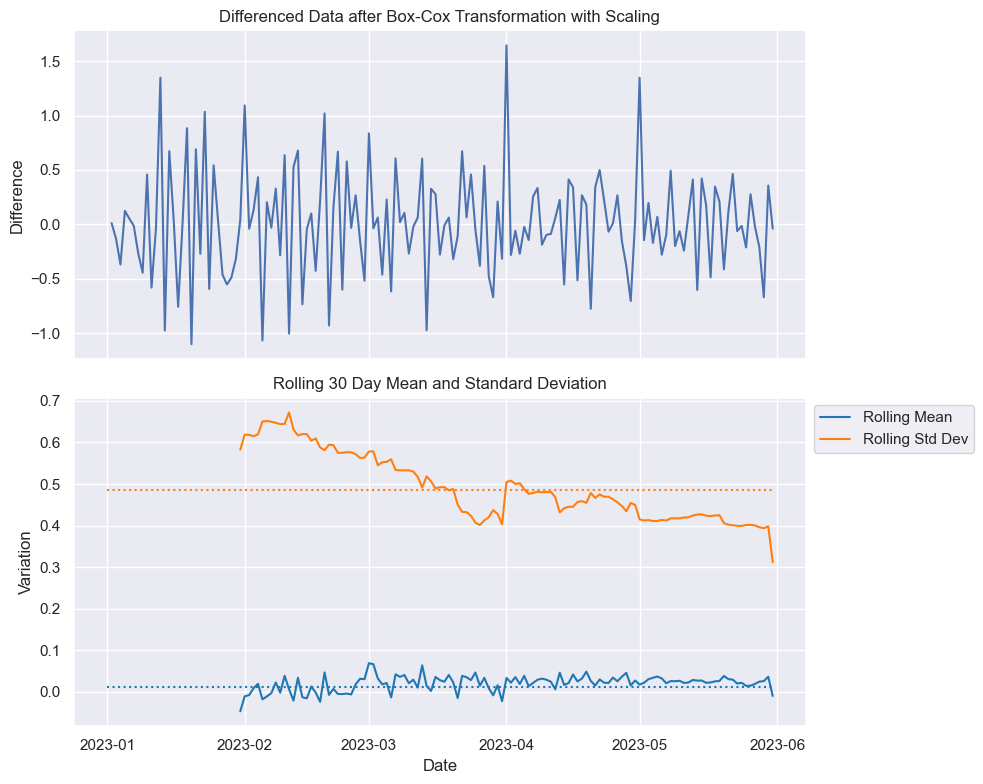

In [16]:
mean_std_view(df_coffee_stationary,'Difference_Scaled_BC',title='Differenced Data after Box-Cox Transformation with Scaling')

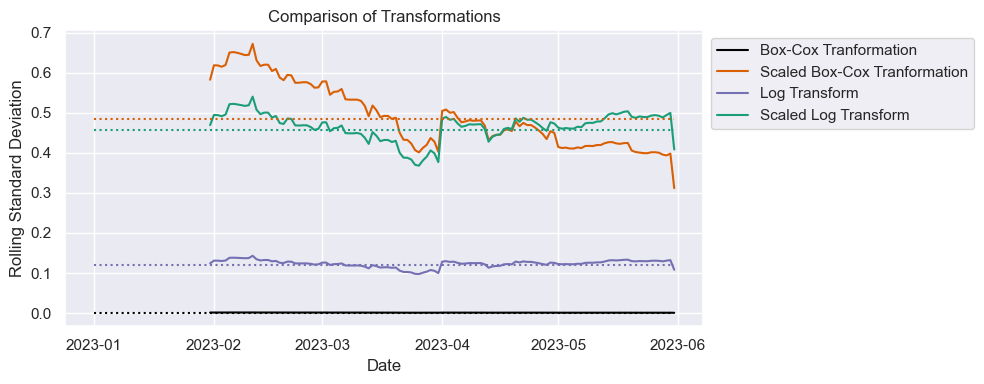

In [28]:
df_coffee_std = df_coffee_stationary.copy()

plt.figure(figsize = (10,4))

df_coffee_std['rolling_std_bc'] = df_coffee_stationary['Difference_BC'].rolling(window=30).std()
df_coffee_std['overall_std_bc'] = df_coffee_stationary['Difference_BC'].std()

df_coffee_std['rolling_std_log'] = df_coffee_stationary['Difference_log'].rolling(window=30).std()
df_coffee_std['overall_std_log'] = df_coffee_stationary['Difference_log'].std()

df_coffee_std['rolling_std_bc_scaled'] = df_coffee_stationary['Difference_Scaled_BC'].rolling(window=30).std()
df_coffee_std['overall_std_bc_scaled'] = df_coffee_stationary['Difference_Scaled_BC'].std()

df_coffee_std['rolling_std_log_scaled'] = df_coffee_stationary['Difference_Scaled_log'].rolling(window=30).std()
df_coffee_std['overall_std_log_scaled'] = df_coffee_stationary['Difference_Scaled_log'].std()

tb_black = '#000000'
tb_green ="#1B9E77"
tb_orange =  '#D95F02'
tb_purple = "#7570B3"

ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_bc',errorbar=None,color=tb_black, label = "Box-Cox Tranformation")
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_bc_scaled',errorbar=None,color=tb_orange, label = "Scaled Box-Cox Tranformation")
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_log',errorbar=None,color=tb_purple, label = 'Log Transform')
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_log_scaled',errorbar=None,color=tb_green, label = "Scaled Log Transform")


ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_bc',errorbar=None,linestyle = ':',color= tb_black)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_bc_scaled',errorbar=None,linestyle = ':',color=tb_orange)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_log',errorbar=None,linestyle = ':',color= tb_purple)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_log_scaled',errorbar=None,linestyle = ':',color=tb_green)

ax.set(title = 'Comparison of Transformations',
       xlabel = 'Date',
      ylabel='Rolling Standard Deviation')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig("Images/Stationarity/Comparison of Transformations.png")

plt.show()

#### ADF Test

In [18]:
sets = ['Difference','Difference_log','Difference_BC','Difference_Scaled_BC','Difference_Scaled_log']

for data in sets:
    print(f'Augmented Dickey Fuller Test for the data in {data}:')
    trend_stationary(df_coffee_stationary.dropna(),data)
    print('\n')

Augmented Dickey Fuller Test for the data in Difference:
ADF statistic is -7.80
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_log:
ADF statistic is -7.57
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_BC:
ADF statistic is -7.77
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_Scaled_BC:
ADF statistic is -7.77
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_Scaled_log:
ADF statistic is -7.57
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence




The ACF and PACF plots indicate an MA(1) model or ARIMA(0,1,1) since we took a single difference. An AR(1) model may not be appropriate

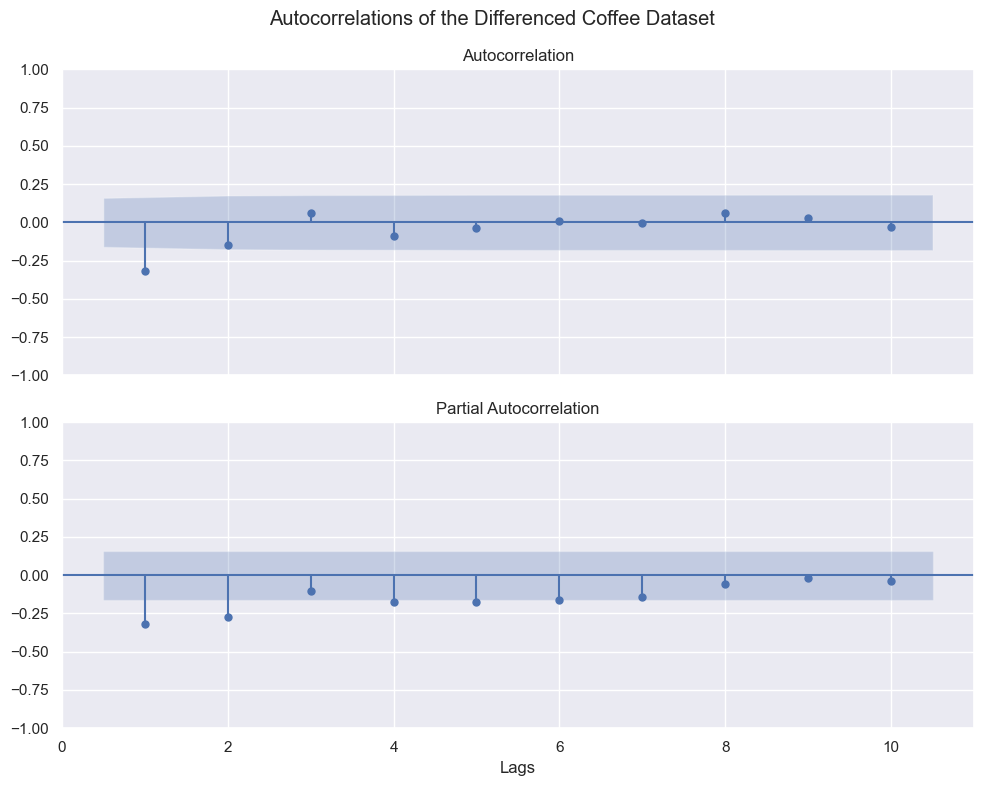

In [19]:
acf_pacf(df_coffee_stationary['Difference'],"Autocorrelations of the Differenced Coffee Dataset")

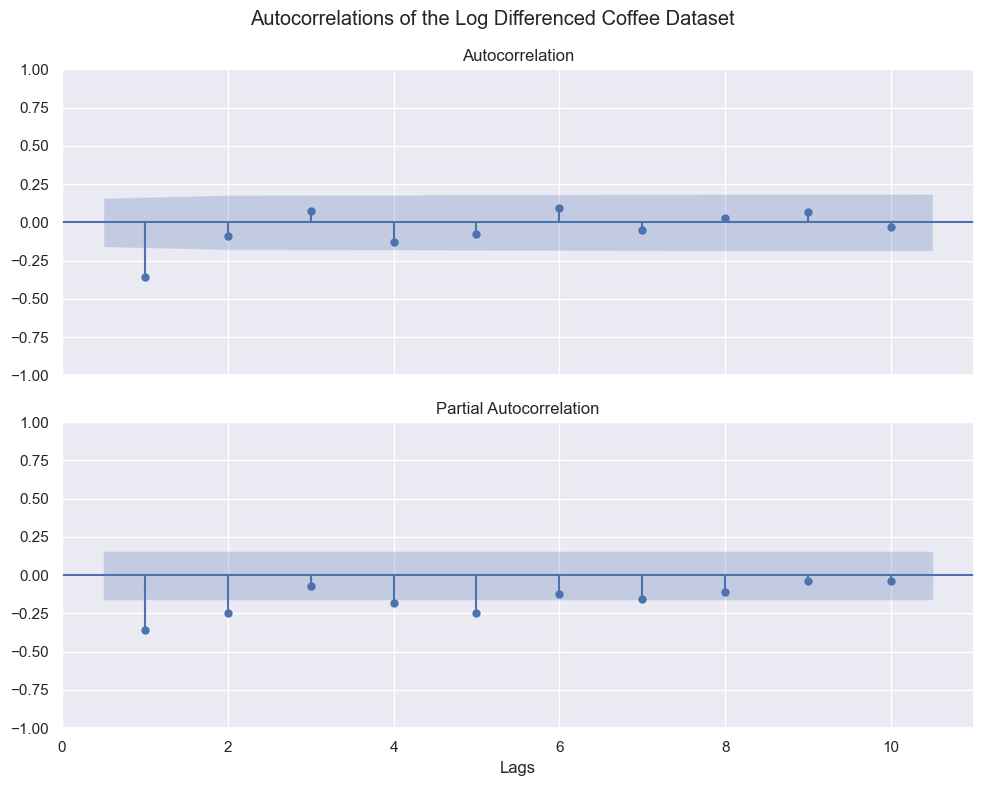

In [20]:
acf_pacf(df_coffee_stationary['Difference_log'],"Autocorrelations of the Log Differenced Coffee Dataset")

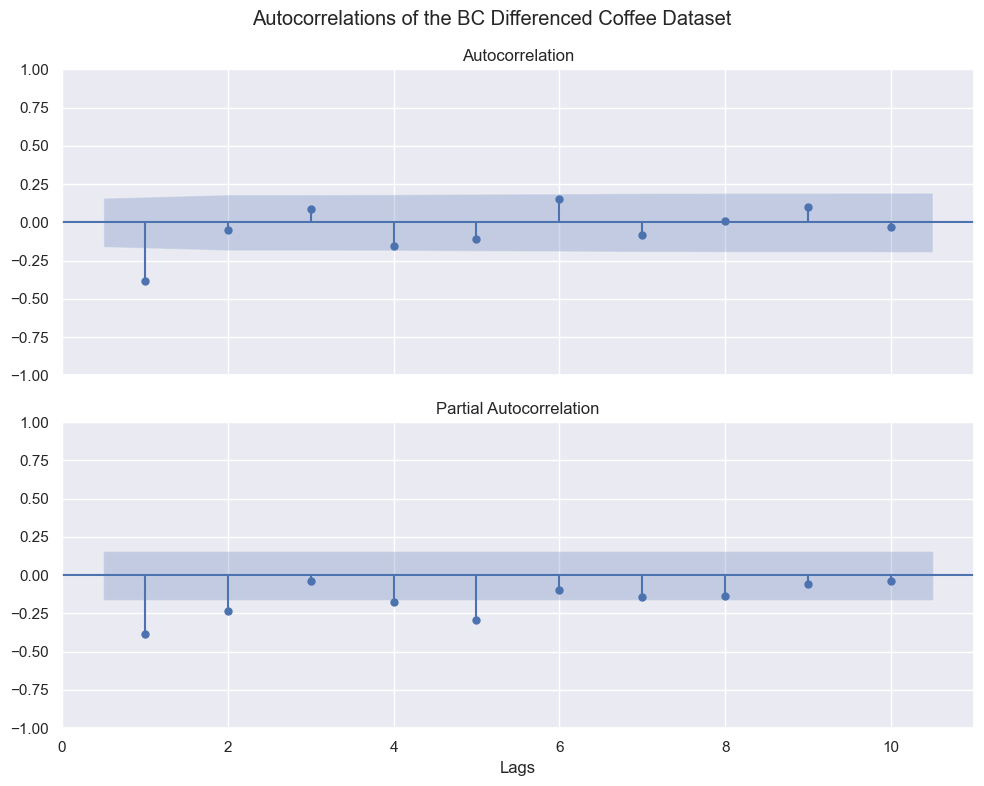

In [21]:
acf_pacf(df_coffee_stationary['Difference_BC'],"Autocorrelations of the BC Differenced Coffee Dataset")

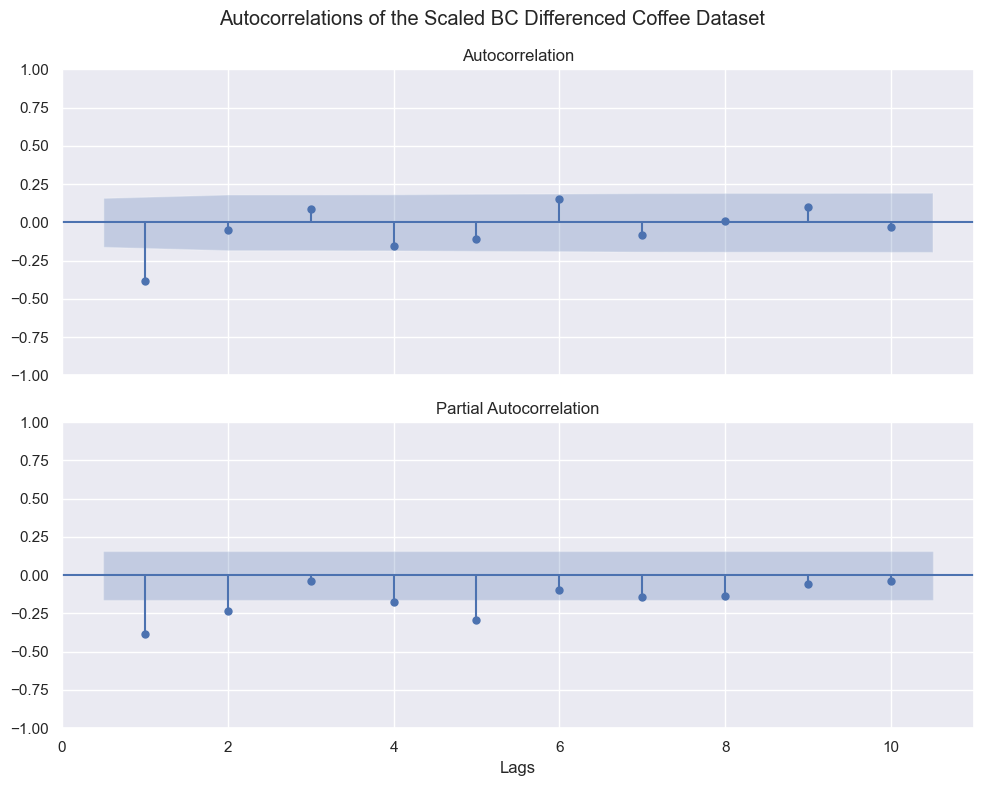

In [22]:
acf_pacf(df_coffee_stationary['Difference_Scaled_BC'],"Autocorrelations of the Scaled BC Differenced Coffee Dataset")

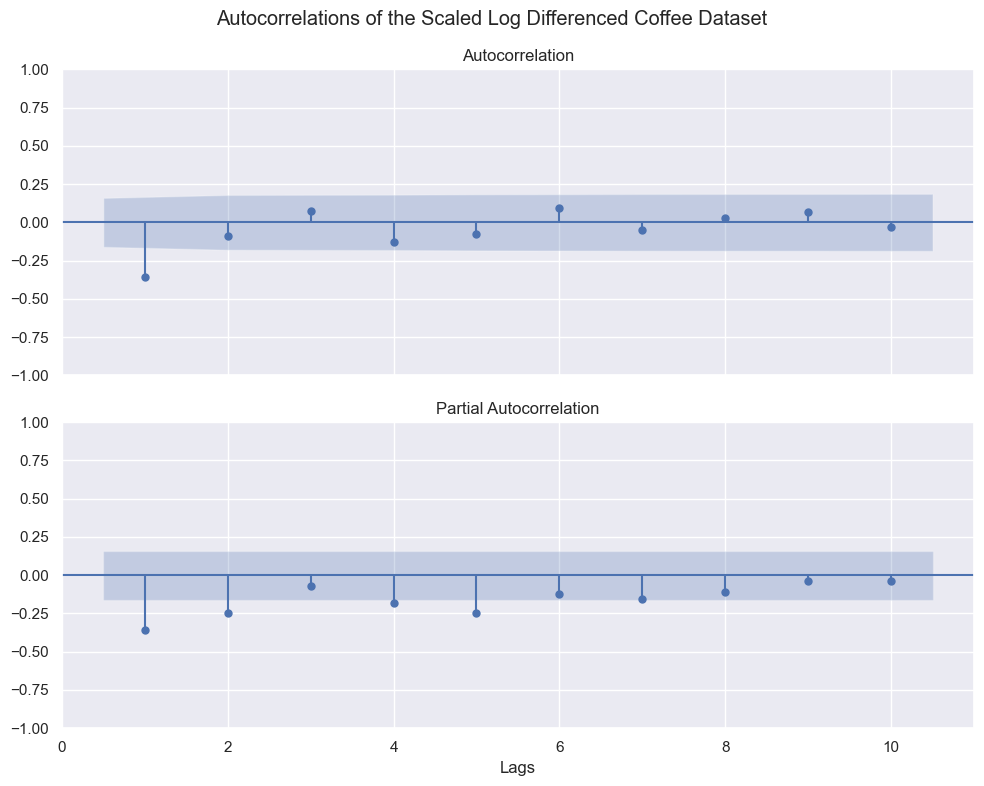

In [23]:
acf_pacf(df_coffee_stationary['Difference_Scaled_log'],"Autocorrelations of the Scaled Log Differenced Coffee Dataset")

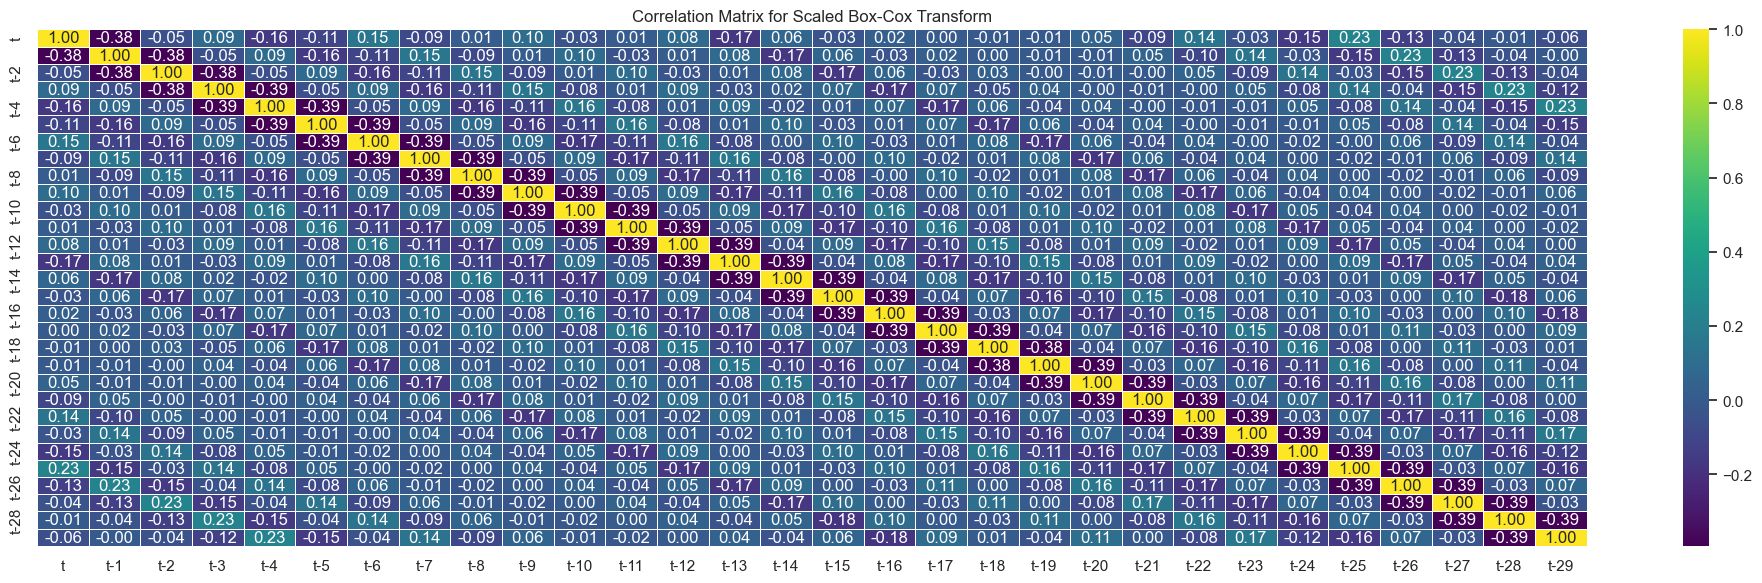

In [24]:
df_bc_scaled = df_coffee_stationary[['Date','Quantity','Scaled_Quantity_BC','Difference_Scaled_BC']].copy()
time_lag(df_bc_scaled,'Difference_Scaled_BC',steps=29)

df_bc_scaled.rename(columns={'Difference_Scaled_BC':'t'},inplace=True)

corr_matrix = df_bc_scaled.drop(columns=['Date','Quantity','Scaled_Quantity_BC']).corr()

plt.figure(figsize=(20, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Scaled Box-Cox Transform')
plt.tight_layout()
plt.savefig("Images/Corr/Correlation Matrix for Scaled Box-Cox Transform.png")
plt.show()

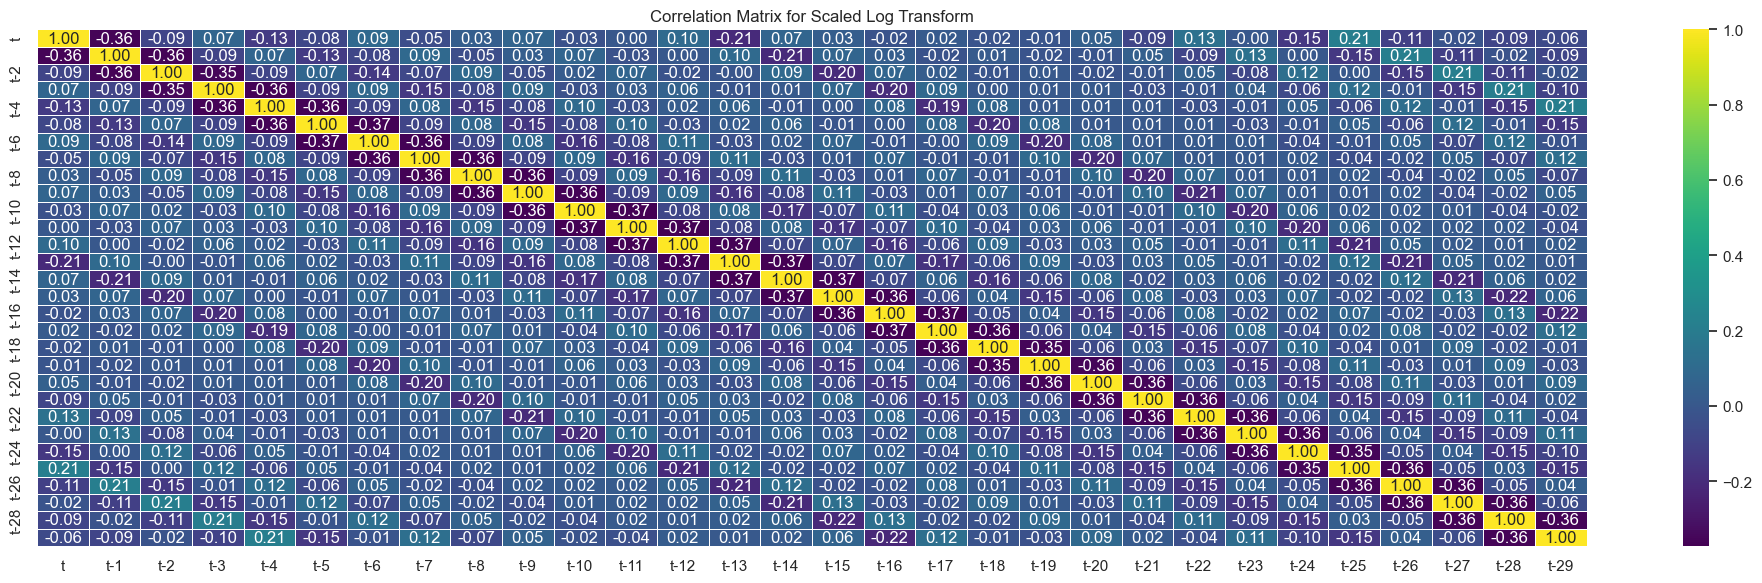

In [25]:
df_log_scaled = df_coffee_stationary[['Date','Quantity','Scaled_Quantity_log','Difference_Scaled_log']].copy()
time_lag(df_log_scaled,'Difference_Scaled_log',steps=29)

df_log_scaled.rename(columns={'Difference_Scaled_log':'t'},inplace=True)

corr_matrix = df_log_scaled.drop(columns=['Date','Quantity','Scaled_Quantity_log']).corr()

plt.figure(figsize=(20, 6))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Scaled Log Transform')
plt.tight_layout()
plt.savefig("Images/Corr/Correlation Matrix for Scaled Log Transform.png")
plt.show()

### Intro to Model Development

#### What does time lagged data look like

In [26]:
#Table to show what lagged data looks like

df_lagged = df_coffee_stationary.copy()
df_lagged = df_lagged[['Date','Quantity','Difference']]
time_lag(df_lagged, lagged_qty= 'Difference', steps=5)
df_lagged.head(8)

,Date,Quantity,Difference,t-1,t-2,t-3,t-4,t-5
0,2023-01-01,375,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,376,1.0,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,365,-11.0,1.0,NaN,NaN,NaN,NaN
3,2023-01-04,337,-28.0,-11.0,1.0,NaN,NaN,NaN
4,2023-01-05,346,9.0,-28.0,-11.0,1.0,NaN,NaN
5,2023-01-06,350,4.0,9.0,-28.0,-11.0,1.0,NaN
6,2023-01-07,349,-1.0,4.0,9.0,-28.0,-11.0,1.0
7,2023-01-08,330,-19.0,-1.0,4.0,9.0,-28.0,-11.0
